## setup

In [1]:
! pip install tensorflow numpy matplotlib torch torchvision pandas

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

## Tensorflow

### Transformation Feature Extractor

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


print("TensorFlow version:", tf.__version__)


# Build Transformation Feature Extractor

def build_dtn(input_shape=(500, 500, 3), tf_channels=12, backbone="resnet", k=4):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for i in range(k):
        if backbone == "resnet":
            shortcut = x
            # 🛠 Match channel dimensions using 1x1 conv
            if x.shape[-1] != 64:
                shortcut = layers.Conv2D(64, 1, padding='same')(shortcut)

            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            x = layers.Conv2D(64, 3, padding='same')(x)
            x = layers.Add()([shortcut, x])
            x = layers.ReLU()(x)
        elif backbone == "densenet":
            dense_input = x
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            x = layers.Concatenate()([dense_input, x])
        else:  # plain CNN
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

        x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(tf_channels, 1, padding='same')(x)
    model = models.Model(inputs, x, name=f"DTN_{backbone}_k{k}")
    return model


# Build Expected Texture Transformer

def expected_texture_transformer(tf_features, eta_exp):
    subtractor = tf_features[..., 0:3]
    adder1 = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2 = tf_features[..., 9:12]

    x = (eta_exp - subtractor)
    x = x + adder1
    x = x * multiplier
    x = x + adder2
    return x


# Define Training Loop

def train_dtn(x_ref, eta_exp, x_ren, epochs=5, batch_size=16, backbone="resnet", k=4):
    dtn_model = build_dtn(backbone=backbone, k=k)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    dataset = tf.data.Dataset.from_tensor_slices((x_ref, eta_exp, x_ren))
    dataset = dataset.shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_xref, batch_etaexp, batch_xren in dataset:
            with tf.GradientTape() as tape:
                tf_features = dtn_model(batch_xref, training=True)

                tf_features = tf.image.resize(tf_features, size=(batch_etaexp.shape[1], batch_etaexp.shape[2]), method='bilinear')

                x_recon = expected_texture_transformer(tf_features, batch_etaexp)
                loss = loss_fn(batch_xren, x_recon)

            grads = tape.gradient(loss, dtn_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, dtn_model.trainable_weights))
            epoch_loss += loss.numpy()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

    return dtn_model


# Real Data Loading (From Files)

def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

# Example folder structure
# /content/
#   ref_images/  --> x_ref (masked rendered object images)
#   exp_textures/ --> eta_exp (expected textures, flat color masked images)
#   ren_images/ --> x_ren (ground truth rendered images)

real_data = False

# You can upload and load your real datasets if available
if os.path.exists('dataset/reference'):
    print("Loading real datasets...")
    x_ref = load_images_from_folder('dataset/reference')
    eta_exp = load_images_from_folder('dataset/texture')
    x_ren = load_images_from_folder('dataset/rendered')
    real_data = True
else:
    print("Real data folders not found. Using dummy random data...")
    num_samples = 100
    x_ref = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)
    eta_exp = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)
    x_ren = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)

print("Data loaded:", x_ref.shape, eta_exp.shape, x_ren.shape)


# Train DTN Model

print("\nStarting DTN Training...")
trained_model = train_dtn(x_ref, eta_exp, x_ren, epochs=25, batch_size=32, backbone="resnet", k=4)


# Save Model
trained_model.save("dtn_model_real.h5")
print("\nModel saved as dtn_model_real.h5 ")



In [ ]:
# Visualize TF and Reconstruction Output

# Visualize 5 Random Predictions
num_visuals = 5
indices = np.random.choice(len(x_ref), size=num_visuals, replace=False)

plt.figure(figsize=(16, num_visuals * 2))

for i, idx in enumerate(indices):
    sample_xref = x_ref[idx:idx+1]
    sample_etaexp = eta_exp[idx:idx+1]
    sample_xren = x_ren[idx:idx+1]

    tf_features = trained_model.predict(sample_xref)
    tf_features = tf.image.resize(tf_features, size=(sample_etaexp.shape[1], sample_etaexp.shape[2]), method='bilinear')
    recon = expected_texture_transformer(tf_features, sample_etaexp).numpy()

    # Split TF into 4 RGB maps
    subtractor = tf_features[..., 0:3]
    adder1     = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2     = tf_features[..., 9:12]

    feature_maps = [subtractor, adder1, multiplier, adder2]
    titles = ['TF: Subtractor', 'TF: Adder1', 'TF: Multiplier', 'TF: Adder2']

    # # Plot
    # plt.figure(figsize=(12, 4))
    # for j in range(4):
    #     plt.subplot(1, 4, j+1)
    #     # Clip values to [0,1] to visualize
    #     plt.imshow(np.clip(feature_maps[j][0], 0, 1))
    #     plt.title(titles[j])
    #     plt.axis('off')
    # plt.suptitle("Visualizing the 4 Stacked RGB Transformation Features from DTN Output", fontsize=14)
    # plt.tight_layout()
    # plt.show()

    # Plot 4 columns: x_ref, eta_exp, x_ren, recon
    for j, img in enumerate([sample_xref[0], sample_etaexp[0], sample_xren[0], recon[0]]):
        plt.subplot(num_visuals, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(["x_ref", "eta_exp", "x_ren", "recon"][j])

plt.suptitle("DTN Reconstruction Results on 5 Random Samples", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## plain nn

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob


2025-05-13 20:32:00.825204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 20:32:00.971573: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 20:32:00.997426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-05-13 20:32:00.997433:

In [ ]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    # structure 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)

    # Crop to match the input shape
    x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)


    # Reshape back to 4D tensor
    # x = tf.keras.layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 64))(x)


    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)  # Output 3 channels

    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [14]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [23]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)

model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(
            [x_ref[:1025], eta_exp[:1025]], 
            x_ren[:1025], 
            epochs=10, 
            batch_size=32, # batch-size dropped from 64 to 32 for structure 3
            validation_split=0.1, 
            callbacks=[ 
                tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            ]
        )


Epoch 1/10


ValueError: in user code:

    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/keras/losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 504 and 500 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_5/conv2d_61/Sigmoid, IteratorGetNext:2)' with input shapes: [?,504,504,3], [?,500,500,3].


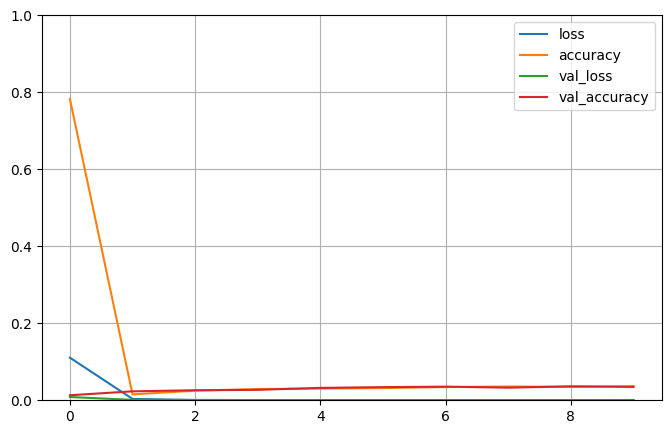

In [5]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

1/1 [==============================] - 0s 271ms/step


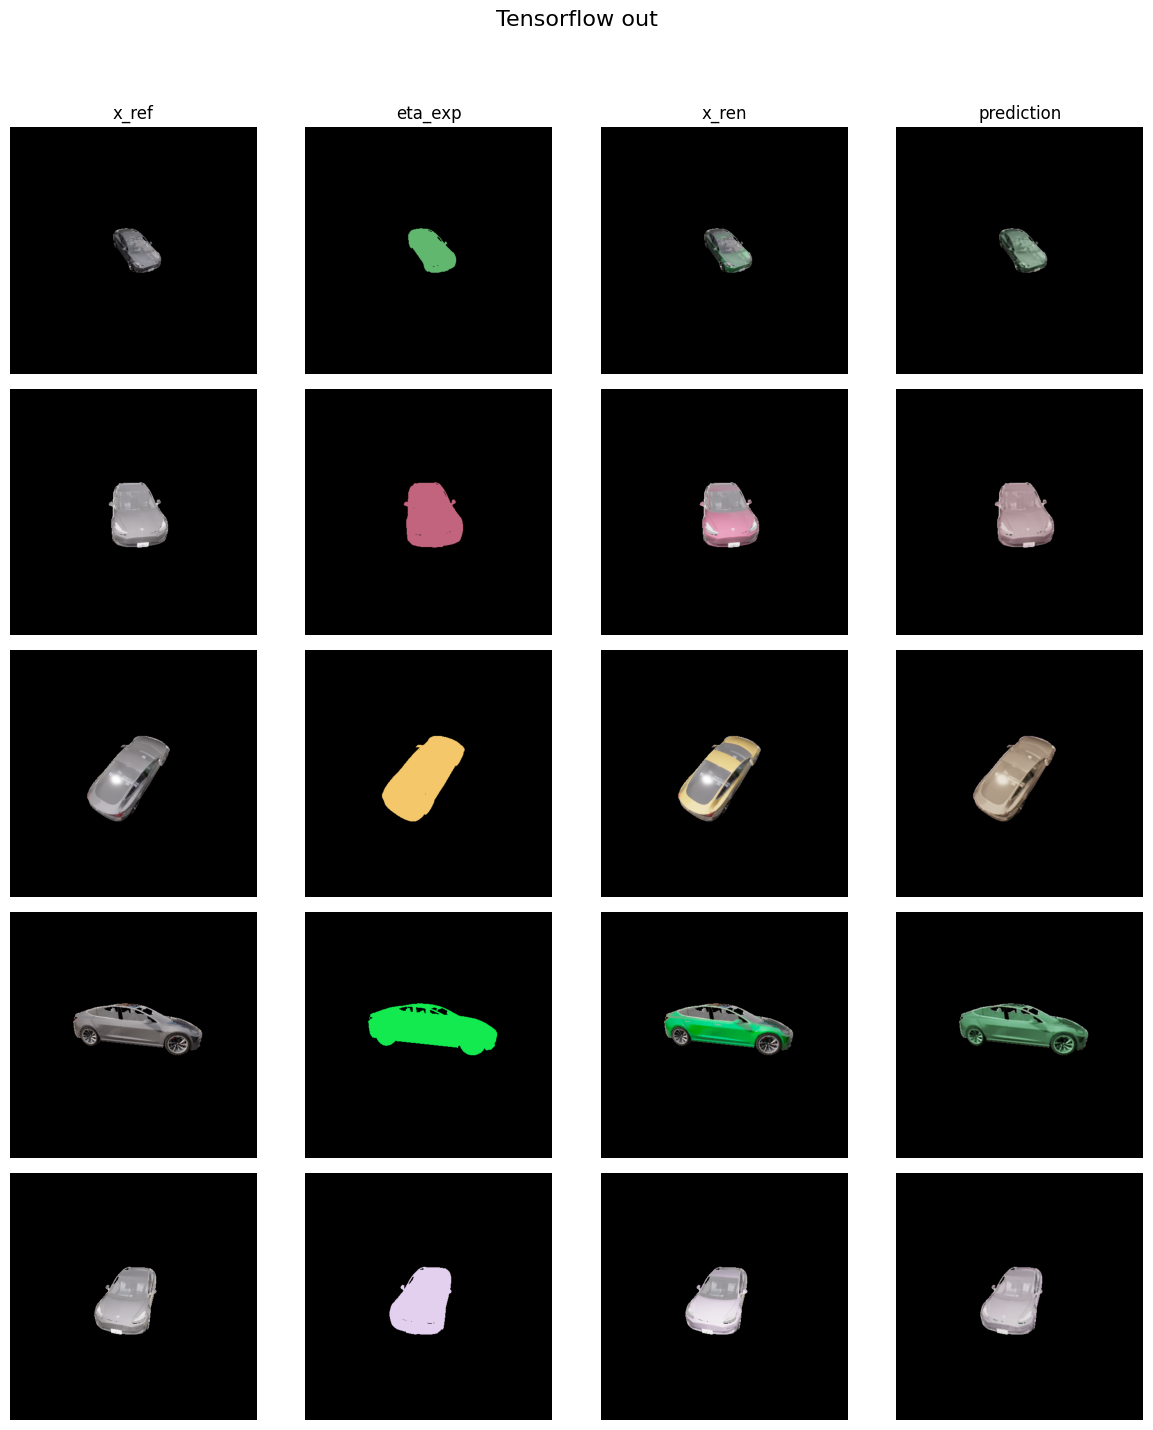

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

# Plot 5 rows × 4 columns (x_ref, eta_exp, x_ren, prediction)
num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction"]

plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    images = [x_ref[i+1025], eta_exp[i+1025], x_ren[i+1025], preds[i]]
    for j in range(4):
        plt.subplot(num_samples, 4, i * 4 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1))
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle("Tensorflow out", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## pytorch

### plain nn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


device = 'cpu'
print(f"Using {device} device")

In [ ]:
class Dtn(nn.Module):
    def __init__(self):
        super(Dtn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),  # 6 channels: x_ref + eta_exp
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),   # Output RGB image
            nn.Sigmoid()  # Keep output in [0, 1]
        )

    def forward(self, x_ref, eta_exp):
        x = torch.cat([x_ref, eta_exp], dim=1)  # Concatenate along channels
        x = self.features(x)
        return x


In [ ]:
import glob
from PIL import Image
import torch
from torchvision import transforms
import numpy as np

# Image size
image_size = (500, 500)

# Define a common transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # Converts to tensor in [0,1]
])

# Get list of filenames
x_ref_paths = sorted(glob.glob("dataset/reference/*.png"))
eta_exp_paths = sorted(glob.glob("dataset/texture/*.png"))
x_ren_paths = sorted(glob.glob("dataset/rendered/*.png"))

# Load all images into lists (or torch tensors)
x_ref = [transform(Image.open(p).convert("RGB")) for p in x_ref_paths]
eta_exp = [transform(Image.open(p).convert("RGB")) for p in eta_exp_paths]
x_ren = [transform(Image.open(p).convert("RGB")) for p in x_ren_paths]

# Stack into full tensors
x_ref = torch.stack(x_ref)       # Shape: (N, 3, H, W)
eta_exp = torch.stack(eta_exp)   # Shape: (N, 3, H, W)
x_ren = torch.stack(x_ren)       # Shape: (N, 3, H, W)

x_ref, eta_exp, x_ren = x_ref.to(device), eta_exp.to(device), x_ren.to(device)

print("Loaded real datasets...")


In [ ]:
model = Dtn().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10


for epoch in range(num_epochs):
    model.train()
    preds = model(x_ref[:500], eta_exp[:500])
    loss = criterion(preds, x_ren[:500])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [ ]:
model.eval()
with torch.no_grad():
    pred = model(x_ref[1025:], eta_exp[1025:]).cpu()

import matplotlib.pyplot as plt
import numpy as np

# Titles per column
titles = ['x_ref', 'eta_exp', 'x_ren', 'prediction']

# Plot: 5 rows × 4 columns
plt.figure(figsize=(14, 10))

for i in range(5):  # for 5 samples
    imgs = [x_ref[i+1025], eta_exp[i+1025], x_ren[i+1025], pred[i]]
    for j in range(4):  # for 4 image types
        ax = plt.subplot(5, 4, i * 4 + j + 1)
        ax.imshow(np.clip(imgs[j].permute(1, 2, 0).cpu().numpy(), 0, 1))
        ax.axis('off')
        if i == 0:
            ax.set_title(titles[j])

plt.suptitle("Pytorch out", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
